In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings('ignore')

from generate_power_grid import generate_power_grid, NodeID
from core import (
    UnifiedPowerGridModel,
    UnifiedIRDropSolver,
    UnifiedHierarchicalResult,
    UnifiedSolveResult,
    create_model_from_synthetic,
    GridSource,
)

## 1. Generate a Test Power Grid

We create a multi-layer power grid with:
- 5 vertical layers (K=5)
- 16 stripes at layer 0
- 20 load nodes
- 4 voltage source pads on top layer

In [2]:
# Generate power grid
G, loads, pads = generate_power_grid(
    K=5,               # 5 layers (0 to 4)
    N0=16,             # 16 stripes at layer 0
    I_N=20,            # 20 load nodes
    N_vsrc=4,          # 4 voltage sources
    max_stripe_res=1.0,
    max_via_res=0.1,
    load_current=0.1,
    seed=42,
    plot=False
)

print(f"Grid Statistics:")
print(f"  Nodes: {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges()}")
print(f"  Load nodes: {len(loads)}")
print(f"  Pad nodes: {len(pads)}")

# Count nodes per layer
layer_counts = {}
for node in G.nodes():
    layer = node.layer
    layer_counts[layer] = layer_counts.get(layer, 0) + 1

print(f"\nNodes per layer:")
for layer in sorted(layer_counts.keys()):
    print(f"  Layer {layer}: {layer_counts[layer]} nodes")

Grid Statistics:
  Nodes: 414
  Edges: 553
  Load nodes: 20
  Pad nodes: 2

Nodes per layer:
  Layer 0: 180 nodes
  Layer 1: 176 nodes
  Layer 2: 40 nodes
  Layer 3: 14 nodes
  Layer 4: 4 nodes


## 2. Create Unified Power Grid Model

We use the factory function `create_model_from_synthetic()` to create a `UnifiedPowerGridModel` from the synthetic grid.

In [3]:
# Create the unified power grid model using factory function
model = create_model_from_synthetic(G, pads, vdd=1.0)

print(f"UnifiedPowerGridModel created with Vdd = {model.vdd} V")
print(f"Source type: {model.source}")
print(f"Reduced system has {len(model.reduced.unknown_nodes)} unknowns")
print(f"Available layers: {model.get_all_layers()}")

UnifiedPowerGridModel created with Vdd = 1.0 V
Source type: GridSource.SYNTHETIC
Reduced system has 412 unknowns
Available layers: [0, 1, 2, 3, 4]


## 3. Visualize PDN Decomposition

Let's visualize how the PDN is decomposed at different partition layers using the unified model's `_decompose_at_layer()` method.

In [4]:
def visualize_decomposition(model, partition_layer, loads, pads, ax=None):
    """Visualize the PDN decomposition at a given partition layer using unified model."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    else:
        fig = ax.figure
    
    # Decompose using unified model
    top_nodes, bottom_nodes, ports, via_edges = model._decompose_at_layer(partition_layer)
    
    # Draw edges
    for u, v in model.graph.edges():
        u_info = model.get_node_info(u)
        v_info = model.get_node_info(v)
        
        if u_info.xy is None or v_info.xy is None:
            continue
        
        x1, y1 = u_info.xy
        x2, y2 = v_info.xy
        
        # Color based on grid membership
        if u in top_nodes and v in top_nodes:
            color = '#3498db'  # blue for top
            alpha = 0.6
        elif u in bottom_nodes and v in bottom_nodes:
            color = '#e74c3c'  # red for bottom
            alpha = 0.6
        else:
            color = '#2ecc71'  # green for interface
            alpha = 0.8
        
        ax.plot([x1, x2], [y1, y2], color=color, alpha=alpha, lw=0.8)
    
    # Draw nodes
    for node in model.graph.nodes():
        node_info = model.get_node_info(node)
        if node_info.xy is None:
            continue
        x, y = node_info.xy
        
        if node in ports:
            ax.scatter(x, y, c='#2ecc71', s=80, marker='s', edgecolors='black', linewidths=1.5, zorder=5)
        elif node in set(pads):
            ax.scatter(x, y, c='gold', s=100, marker='*', edgecolors='black', linewidths=1, zorder=6)
        elif node in set(loads.keys()):
            ax.scatter(x, y, c='#9b59b6', s=50, marker='o', edgecolors='black', linewidths=0.5, zorder=4)
        elif node in top_nodes:
            ax.scatter(x, y, c='#3498db', s=20, alpha=0.6, zorder=3)
        else:
            ax.scatter(x, y, c='#e74c3c', s=20, alpha=0.6, zorder=3)
    
    ax.set_aspect('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'PDN Decomposition at Layer {partition_layer}\n'
                 f'Top: {len(top_nodes)} nodes, Bottom: {len(bottom_nodes)} nodes, Ports: {len(ports)}')
    
    # Legend
    legend_elements = [
        Patch(facecolor='#3498db', label=f'Top-grid ({len(top_nodes)} nodes)'),
        Patch(facecolor='#e74c3c', label=f'Bottom-grid ({len(bottom_nodes)} nodes)'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='#2ecc71',
               markeredgecolor='black', markersize=10, label=f'Ports ({len(ports)})'),
        Line2D([0], [0], marker='*', color='w', markerfacecolor='gold',
               markeredgecolor='black', markersize=12, label=f'Pads ({len(pads)})'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#9b59b6',
               markeredgecolor='black', markersize=8, label=f'Loads ({len(loads)})'),
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    return fig, ax

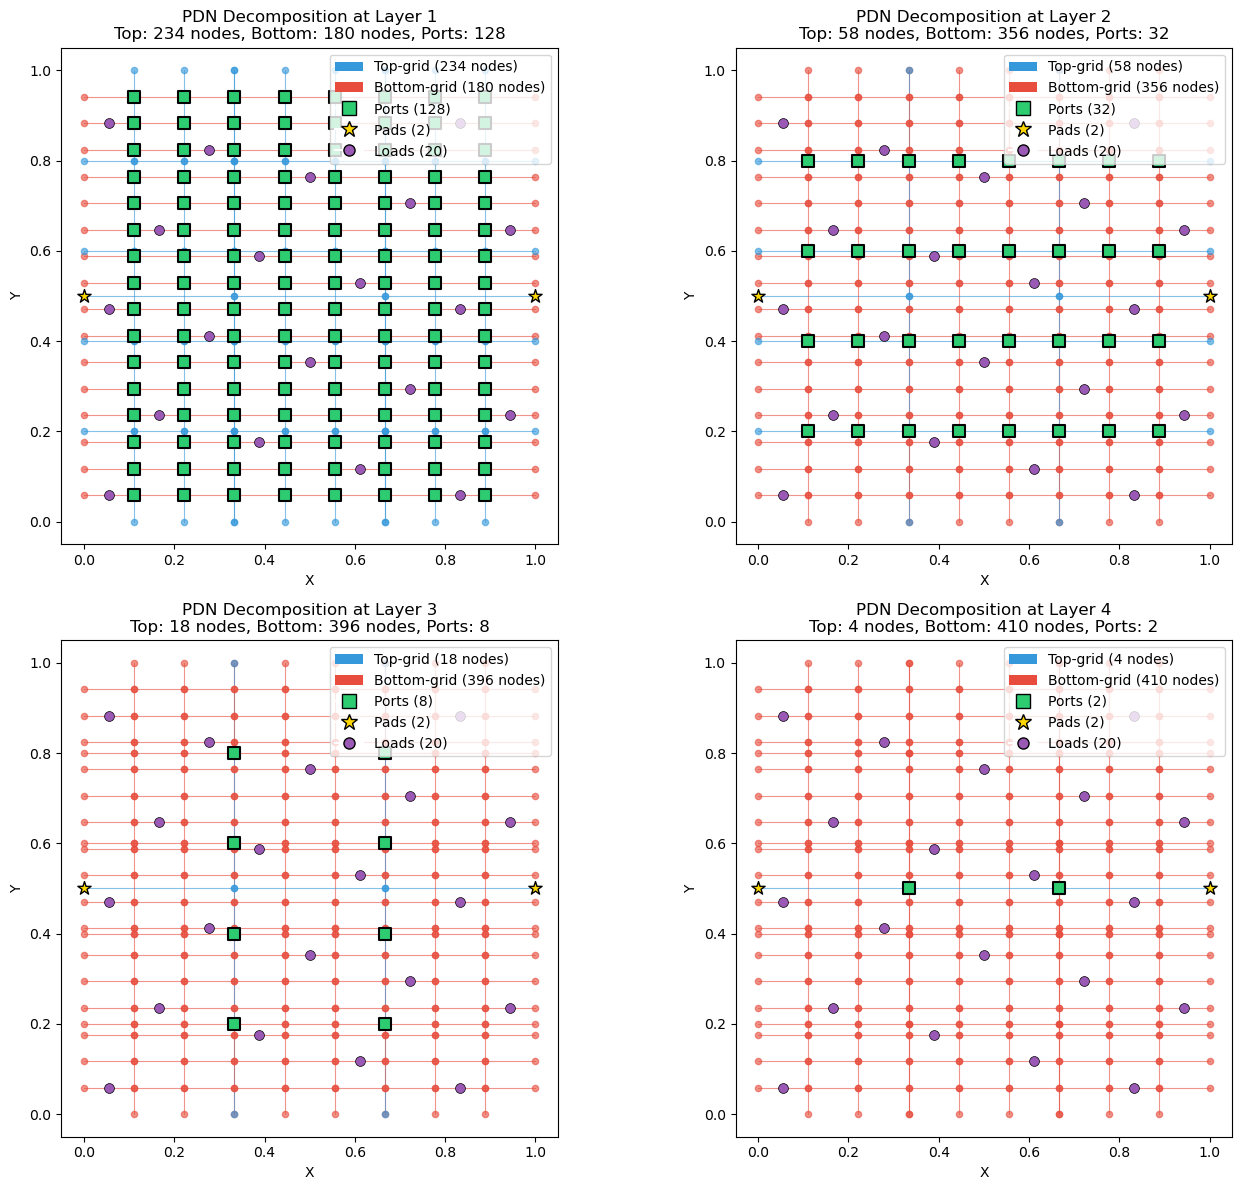

In [5]:
%matplotlib inline
# Visualize decomposition at different layers
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for i, partition_layer in enumerate([1, 2, 3, 4]):
    ax = axes[i // 2, i % 2]
    visualize_decomposition(model, partition_layer, loads, pads, ax=ax)

plt.tight_layout()
plt.show()

## 4. Compare Flat vs Hierarchical Solver

Let's compare the results of the flat (direct) solver with the hierarchical solver using `UnifiedIRDropSolver`.

In [6]:
# Create unified solver
solver = UnifiedIRDropSolver(model)

# Flat (direct) solve
flat_result = solver.solve(loads)
flat_voltages = flat_result.voltages
flat_drop = flat_result.ir_drop

print("Flat Solver Results (UnifiedIRDropSolver):")
print(f"  Min voltage: {min(flat_voltages.values()):.6f} V")
print(f"  Max voltage: {max(flat_voltages.values()):.6f} V")
print(f"  Max IR-drop: {max(flat_drop.values()):.6f} V")
print(f"  Avg IR-drop: {np.mean(list(flat_drop.values())):.6f} V")

# Show summary
summary = solver.summarize(flat_result)
print(f"\nSummary: {summary}")

Flat Solver Results (UnifiedIRDropSolver):
  Min voltage: 0.924888 V
  Max voltage: 1.000000 V
  Max IR-drop: 0.075112 V
  Avg IR-drop: 0.058709 V

Summary: {'nominal_voltage': 1.0, 'min_voltage': 0.9248883757024725, 'max_voltage': 0.9791698855870822, 'max_drop': 0.07511162429752749, 'avg_drop': 0.05899445020488988}


In [7]:
# Hierarchical solve at different partition layers
hier_results = {}

for partition_layer in [1, 2, 3]:
    result = solver.solve_hierarchical(loads, partition_layer=partition_layer, top_k=5)
    hier_results[partition_layer] = result
    
    print(f"\nHierarchical Solver (partition_layer={partition_layer}):")
    print(f"  Ports: {len(result.port_nodes)}")
    print(f"  Min voltage: {min(result.voltages.values()):.6f} V")
    print(f"  Max voltage: {max(result.voltages.values()):.6f} V")
    print(f"  Max IR-drop: {max(result.ir_drop.values()):.6f} V")
    print(f"  Avg IR-drop: {np.mean(list(result.ir_drop.values())):.6f} V")


Hierarchical Solver (partition_layer=1):
  Ports: 128
  Min voltage: 0.923450 V
  Max voltage: 1.000000 V
  Max IR-drop: 0.076550 V
  Avg IR-drop: 0.059504 V

Hierarchical Solver (partition_layer=2):
  Ports: 32
  Min voltage: 0.922176 V
  Max voltage: 1.000000 V
  Max IR-drop: 0.077824 V
  Avg IR-drop: 0.059704 V

Hierarchical Solver (partition_layer=3):
  Ports: 8
  Min voltage: 0.925125 V
  Max voltage: 1.000000 V
  Max IR-drop: 0.074875 V
  Avg IR-drop: 0.058656 V


In [8]:
# Compare voltage errors
print("\nVoltage Error Analysis (vs Flat Solver):")
print("="*60)

for partition_layer, result in hier_results.items():
    errors = []
    for node in flat_voltages:
        if node in result.voltages:
            error = abs(flat_voltages[node] - result.voltages[node])
            errors.append(error)
    
    errors = np.array(errors)
    print(f"\nPartition Layer {partition_layer}:")
    print(f"  Max error:  {errors.max():.6f} V ({errors.max()*100:.4f}% of Vdd)")
    print(f"  Mean error: {errors.mean():.6f} V ({errors.mean()*100:.4f}% of Vdd)")
    print(f"  RMS error:  {np.sqrt((errors**2).mean()):.6f} V")


Voltage Error Analysis (vs Flat Solver):

Partition Layer 1:
  Max error:  0.005418 V (0.5418% of Vdd)
  Mean error: 0.001548 V (0.1548% of Vdd)
  RMS error:  0.001927 V

Partition Layer 2:
  Max error:  0.006394 V (0.6394% of Vdd)
  Mean error: 0.001354 V (0.1354% of Vdd)
  RMS error:  0.001763 V

Partition Layer 3:
  Max error:  0.000655 V (0.0655% of Vdd)
  Mean error: 0.000155 V (0.0155% of Vdd)
  RMS error:  0.000183 V


## 5. Visualize Voltage and IR-Drop Maps

In [9]:
def plot_voltage_comparison(model, flat_voltages, hier_result, partition_layer):
    """Plot voltage comparison between flat and hierarchical solver."""
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Get voltage range
    all_voltages = list(flat_voltages.values()) + list(hier_result.voltages.values())
    vmin, vmax = min(all_voltages), max(all_voltages)
    
    for ax_idx, (title, voltages) in enumerate([
        ('Flat Solver', flat_voltages),
        (f'Hierarchical (M_p={partition_layer})', hier_result.voltages),
    ]):
        ax = axes[ax_idx]
        
        # Draw edges
        for u, v in model.graph.edges():
            u_info = model.get_node_info(u)
            v_info = model.get_node_info(v)
            if u_info.xy is None or v_info.xy is None:
                continue
            x1, y1 = u_info.xy
            x2, y2 = v_info.xy
            ax.plot([x1, x2], [y1, y2], 'k-', alpha=0.2, lw=0.5)
        
        # Draw nodes colored by voltage
        xs, ys, vs = [], [], []
        for node in model.graph.nodes():
            node_info = model.get_node_info(node)
            if node_info.xy is None:
                continue
            x, y = node_info.xy
            xs.append(x)
            ys.append(y)
            vs.append(voltages.get(node, model.vdd))
        
        sc = ax.scatter(xs, ys, c=vs, cmap='RdYlGn', vmin=vmin, vmax=vmax, s=30, edgecolors='k', linewidths=0.3)
        plt.colorbar(sc, ax=ax, label='Voltage (V)')
        
        ax.set_aspect('equal')
        ax.set_title(title)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
    
    # Plot error
    ax = axes[2]
    for u, v in model.graph.edges():
        u_info = model.get_node_info(u)
        v_info = model.get_node_info(v)
        if u_info.xy is None or v_info.xy is None:
            continue
        x1, y1 = u_info.xy
        x2, y2 = v_info.xy
        ax.plot([x1, x2], [y1, y2], 'k-', alpha=0.2, lw=0.5)
    
    xs, ys, errs = [], [], []
    for node in model.graph.nodes():
        node_info = model.get_node_info(node)
        if node_info.xy is None:
            continue
        x, y = node_info.xy
        xs.append(x)
        ys.append(y)
        flat_v = flat_voltages.get(node, model.vdd)
        hier_v = hier_result.voltages.get(node, model.vdd)
        errs.append(abs(flat_v - hier_v) * 1000)  # mV
    
    sc = ax.scatter(xs, ys, c=errs, cmap='hot_r', s=30, edgecolors='k', linewidths=0.3)
    plt.colorbar(sc, ax=ax, label='Error (mV)')
    
    ax.set_aspect('equal')
    ax.set_title('Voltage Error')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    plt.tight_layout()
    return fig

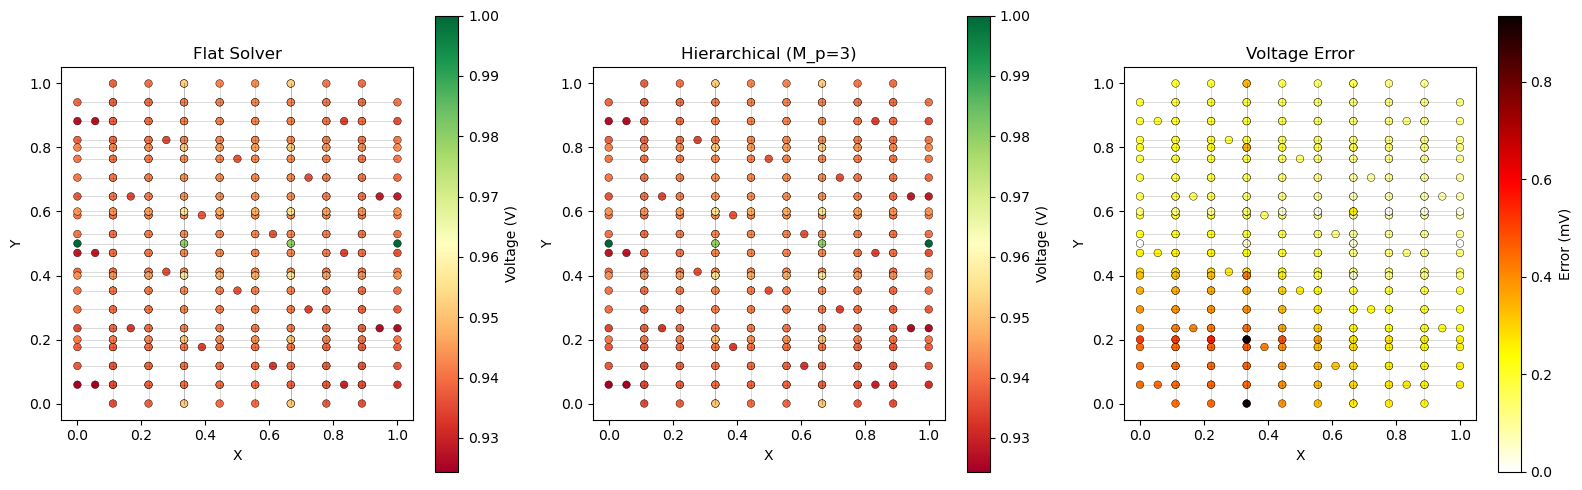

In [10]:
# Plot comparison for partition layer 3
partition_layer = 3
fig = plot_voltage_comparison(model, flat_voltages, hier_results[partition_layer], partition_layer=partition_layer)
plt.show()

## 6. Analyze Current Aggregation to Ports

In [10]:
# Examine current aggregation for a specific partition layer
partition_layer = 3
result = hier_results[partition_layer]

print(f"Current Aggregation Analysis (partition_layer={partition_layer})")
print("="*60)

print(f"\nTotal load current: {sum(loads.values()):.4f} A")
print(f"Total port current: {sum(result.port_currents.values()):.4f} A")

print(f"\nPort currents:")
for port, current in sorted(result.port_currents.items(), key=lambda x: -x[1]):
    if current > 0:
        print(f"  {port}: {current:.6f} A")

print(f"\nAggregation map (first 5 loads):")
for i, (load, contributions) in enumerate(result.aggregation_map.items()):
    if i >= 5:
        break
    print(f"\n  Load {load}:")
    print(f"    Original current: {loads[load]:.6f} A")
    for port, weight, contrib in contributions:
        print(f"    -> Port {port}: weight={weight:.3f}, current={contrib:.6f} A")

Current Aggregation Analysis (partition_layer=3)

Total load current: 2.0000 A
Total port current: 2.0000 A

Port currents:
  NodeID(layer=3, idx=9): 0.309447 A
  NodeID(layer=3, idx=5): 0.291212 A
  NodeID(layer=3, idx=10): 0.284293 A
  NodeID(layer=3, idx=6): 0.271265 A
  NodeID(layer=3, idx=8): 0.215311 A
  NodeID(layer=3, idx=4): 0.213404 A
  NodeID(layer=3, idx=7): 0.208286 A
  NodeID(layer=3, idx=11): 0.206782 A

Aggregation map (first 5 loads):

  Load NodeID(layer=0, idx=160):
    Original current: 0.100000 A
    -> Port NodeID(layer=3, idx=4): weight=0.241, current=0.024064 A
    -> Port NodeID(layer=3, idx=5): weight=0.227, current=0.022739 A
    -> Port NodeID(layer=3, idx=8): weight=0.195, current=0.019516 A
    -> Port NodeID(layer=3, idx=9): weight=0.186, current=0.018635 A
    -> Port NodeID(layer=3, idx=6): weight=0.150, current=0.015046 A

  Load NodeID(layer=0, idx=161):
    Original current: 0.100000 A
    -> Port NodeID(layer=3, idx=8): weight=0.244, current=0.02436

## 7. Compare Weighting Methods

Compare effective resistance weighting vs shortest path resistance weighting.

In [11]:
partition_layer = 3

# Effective resistance weighting
result_eff = solver.solve_hierarchical(
    loads, partition_layer=partition_layer, top_k=5, weighting="effective"
)

# Shortest path resistance weighting
result_sp = solver.solve_hierarchical(
    loads, partition_layer=partition_layer, top_k=5, weighting="shortest_path"
)

print(f"Weighting Method Comparison (partition_layer={partition_layer})")
print("="*60)

print(f"\nEffective Resistance Weighting:")
print(f"  Max IR-drop: {max(result_eff.ir_drop.values()):.6f} V")
print(f"  Avg IR-drop: {np.mean(list(result_eff.ir_drop.values())):.6f} V")

print(f"\nShortest Path Resistance Weighting:")
print(f"  Max IR-drop: {max(result_sp.ir_drop.values()):.6f} V")
print(f"  Avg IR-drop: {np.mean(list(result_sp.ir_drop.values())):.6f} V")

# Error vs flat solve
errors_eff = [abs(flat_voltages[n] - result_eff.voltages[n]) for n in flat_voltages if n in result_eff.voltages]
errors_sp = [abs(flat_voltages[n] - result_sp.voltages[n]) for n in flat_voltages if n in result_sp.voltages]

print(f"\nError vs Flat Solver:")
print(f"  Effective R:    max={max(errors_eff)*1000:.4f} mV, mean={np.mean(errors_eff)*1000:.4f} mV")
print(f"  Shortest Path:  max={max(errors_sp)*1000:.4f} mV, mean={np.mean(errors_sp)*1000:.4f} mV")

Weighting Method Comparison (partition_layer=3)

Effective Resistance Weighting:
  Max IR-drop: 0.075552 V
  Avg IR-drop: 0.058927 V

Shortest Path Resistance Weighting:
  Max IR-drop: 0.074875 V
  Avg IR-drop: 0.058656 V

Error vs Flat Solver:
  Effective R:    max=0.9362 mV, mean=0.2211 mV
  Shortest Path:  max=0.6553 mV, mean=0.1554 mV


In [12]:
# Compare aggregation between weighting methods
print("\nAggregation Comparison (first 3 loads):")
print("-"*60)

for i, load in enumerate(result_eff.aggregation_map.keys()):
    if i >= 3:
        break
    
    print(f"\nLoad: {load}")
    print(f"  Effective R weighting:")
    for port, weight, _ in result_eff.aggregation_map[load]:
        print(f"    -> {port}: {weight:.3f}")
    
    print(f"  Shortest path weighting:")
    if load in result_sp.aggregation_map:
        for port, weight, _ in result_sp.aggregation_map[load]:
            print(f"    -> {port}: {weight:.3f}")


Aggregation Comparison (first 3 loads):
------------------------------------------------------------

Load: NodeID(layer=0, idx=160)
  Effective R weighting:
    -> NodeID(layer=3, idx=4): 0.411
    -> NodeID(layer=3, idx=5): 0.205
    -> NodeID(layer=3, idx=8): 0.179
    -> NodeID(layer=3, idx=9): 0.112
    -> NodeID(layer=3, idx=6): 0.094
  Shortest path weighting:
    -> NodeID(layer=3, idx=4): 0.241
    -> NodeID(layer=3, idx=5): 0.227
    -> NodeID(layer=3, idx=8): 0.195
    -> NodeID(layer=3, idx=9): 0.186
    -> NodeID(layer=3, idx=6): 0.150

Load: NodeID(layer=0, idx=161)
  Effective R weighting:
    -> NodeID(layer=3, idx=8): 0.409
    -> NodeID(layer=3, idx=9): 0.201
    -> NodeID(layer=3, idx=4): 0.185
    -> NodeID(layer=3, idx=5): 0.114
    -> NodeID(layer=3, idx=10): 0.092
  Shortest path weighting:
    -> NodeID(layer=3, idx=8): 0.244
    -> NodeID(layer=3, idx=9): 0.229
    -> NodeID(layer=3, idx=4): 0.194
    -> NodeID(layer=3, idx=5): 0.185
    -> NodeID(layer=3, idx

## 8. Effect of top_k Parameter

In [13]:
partition_layer = 2

print(f"Effect of top_k Parameter (partition_layer={partition_layer})")
print("="*60)

for top_k in [1, 2, 3, 4, 5]:
    result = solver.solve_hierarchical(
        loads, partition_layer=partition_layer, top_k=top_k, weighting="effective"
    )
    
    errors = [abs(flat_voltages[n] - result.voltages[n]) for n in flat_voltages if n in result.voltages]
    
    print(f"\ntop_k={top_k}:")
    print(f"  Max IR-drop: {max(result.ir_drop.values()):.6f} V")
    print(f"  Error vs flat: max={max(errors)*1000:.4f} mV, mean={np.mean(errors)*1000:.4f} mV")

Effect of top_k Parameter (partition_layer=2)

top_k=1:
  Max IR-drop: 0.081800 V
  Error vs flat: max=17.0326 mV, mean=2.7732 mV

top_k=2:
  Max IR-drop: 0.080414 V
  Error vs flat: max=12.9881 mV, mean=2.4666 mV

top_k=3:
  Max IR-drop: 0.079732 V
  Error vs flat: max=9.6018 mV, mean=2.0524 mV

top_k=4:
  Max IR-drop: 0.079098 V
  Error vs flat: max=8.1646 mV, mean=1.8509 mV

top_k=5:
  Max IR-drop: 0.078713 V
  Error vs flat: max=8.6363 mV, mean=1.6623 mV


## 9. Port Voltage Analysis

In [14]:
result = hier_results[2]

print(f"Port Voltage Analysis (partition_layer={result.partition_layer})")
print("="*60)

print(f"\nPort voltages (sorted by voltage):")
for port, voltage in sorted(result.port_voltages.items(), key=lambda x: x[1]):
    ir_drop = model.vdd - voltage
    current = result.port_currents.get(port, 0)
    print(f"  {port}: V={voltage:.6f} V, IR-drop={ir_drop*1000:.2f} mV, I={current:.6f} A")

print(f"\nPort voltage statistics:")
port_voltages = list(result.port_voltages.values())
print(f"  Min: {min(port_voltages):.6f} V")
print(f"  Max: {max(port_voltages):.6f} V")
print(f"  Mean: {np.mean(port_voltages):.6f} V")
print(f"  Std: {np.std(port_voltages):.6f} V")

Port Voltage Analysis (partition_layer=2)

Port voltages (sorted by voltage):
  NodeID(layer=2, idx=36): V=0.934781 V, IR-drop=65.22 mV, I=0.081675 A
  NodeID(layer=2, idx=32): V=0.937050 V, IR-drop=62.95 mV, I=0.082921 A
  NodeID(layer=2, idx=8): V=0.937491 V, IR-drop=62.51 mV, I=0.063033 A
  NodeID(layer=2, idx=12): V=0.939242 V, IR-drop=60.76 mV, I=0.062786 A
  NodeID(layer=2, idx=24): V=0.940017 V, IR-drop=59.98 mV, I=0.059538 A
  NodeID(layer=2, idx=20): V=0.940067 V, IR-drop=59.93 mV, I=0.094352 A
  NodeID(layer=2, idx=11): V=0.940078 V, IR-drop=59.92 mV, I=0.061453 A
  NodeID(layer=2, idx=28): V=0.941622 V, IR-drop=58.38 mV, I=0.081006 A
  NodeID(layer=2, idx=39): V=0.941784 V, IR-drop=58.22 mV, I=0.041712 A
  NodeID(layer=2, idx=15): V=0.941785 V, IR-drop=58.21 mV, I=0.061453 A
  NodeID(layer=2, idx=16): V=0.942737 V, IR-drop=57.26 mV, I=0.060980 A
  NodeID(layer=2, idx=35): V=0.942942 V, IR-drop=57.06 mV, I=0.060351 A
  NodeID(layer=2, idx=23): V=0.943284 V, IR-drop=56.72 mV, 

## 9b. Validate Bottom-Grid Solve with Flat Solver Port Voltages

This validation isolates the bottom-grid solver by using the **exact port voltages from the flat solver** as Dirichlet boundary conditions. If the bottom-grid solver is correct, the resulting voltages should match the flat solver's bottom-grid voltages exactly.

This helps distinguish between:
1. **Errors from current aggregation** (approximating how load currents map to ports)
2. **Errors from the sub-grid solve itself** (should be near-zero if solver is correct)

In [15]:
# Validate bottom-grid solve using flat solver port voltages as Dirichlet BCs
partition_layer = 2

print(f"Bottom-Grid Solver Validation (partition_layer={partition_layer})")
print("="*70)
print("Using flat solver port voltages as Dirichlet boundary conditions")
print("="*70)

# Decompose the PDN using unified model
top_nodes, bottom_nodes, ports, via_edges = model._decompose_at_layer(partition_layer)

# Get the flat solver's port voltages (ground truth)
flat_port_voltages = {p: flat_voltages[p] for p in ports}

print(f"\nDecomposition:")
print(f"  Top-grid nodes: {len(top_nodes)}")
print(f"  Bottom-grid nodes: {len(bottom_nodes)}")
print(f"  Port nodes: {len(ports)}")

print(f"\nFlat solver port voltages (used as Dirichlet BCs):")
for port, v in sorted(flat_port_voltages.items(), key=lambda x: x[1]):
    print(f"  {port}: {v:.6f} V")

# Build bottom-grid system with ports as Dirichlet nodes
bottom_subgrid = bottom_nodes | ports
bottom_system = model._build_subgrid_system(
    subgrid_nodes=bottom_subgrid,
    dirichlet_nodes=ports,
    dirichlet_voltage=model.vdd,  # Will be overridden
)

assert bottom_system is not None, "Failed to build bottom-grid system"

# Get bottom-grid currents (original load currents in bottom-grid)
bottom_grid_currents = {n: c for n, c in loads.items() if n in bottom_nodes}

print(f"\nBottom-grid loads: {len(bottom_grid_currents)}")
print(f"Total bottom-grid current: {sum(bottom_grid_currents.values()):.6f} A")

# Solve bottom-grid with FLAT solver's port voltages as Dirichlet BC
validated_bottom_voltages = model._solve_subgrid(
    reduced_system=bottom_system,
    current_injections=bottom_grid_currents,
    dirichlet_voltages=flat_port_voltages,  # Use exact flat solver port voltages
)

# Compare with flat solver's bottom-grid voltages
print(f"\n" + "-"*70)
print("Validation Results: Bottom-Grid Voltages vs Flat Solver")
print("-"*70)

errors = []
for node in bottom_nodes:
    if node in validated_bottom_voltages and node in flat_voltages:
        error = abs(validated_bottom_voltages[node] - flat_voltages[node])
        errors.append(error)

errors = np.array(errors)

print(f"\nBottom-grid voltage errors (validated vs flat solver):")
print(f"  Max error:  {errors.max():.2e} V ({errors.max()*1e6:.4f} µV)")
print(f"  Mean error: {errors.mean():.2e} V ({errors.mean()*1e6:.4f} µV)")
print(f"  RMS error:  {np.sqrt((errors**2).mean()):.2e} V")

# Check if errors are within numerical precision
if errors.max() < 1e-10:
    print(f"\n✓ VALIDATION PASSED: Bottom-grid solver produces exact results")
    print(f"  All errors are within numerical precision (< 1e-10 V)")
elif errors.max() < 1e-6:
    print(f"\n✓ VALIDATION PASSED: Bottom-grid solver produces accurate results")
    print(f"  All errors are < 1 µV (acceptable numerical error)")
else:
    print(f"\n✗ VALIDATION ISSUE: Unexpected errors in bottom-grid solve")
    print(f"  Max error {errors.max():.6f} V exceeds expected numerical precision")

# Show a few example comparisons
print(f"\nSample node comparisons (first 5 bottom-grid nodes):")
for i, node in enumerate(list(bottom_nodes)[:5]):
    flat_v = flat_voltages.get(node, 0)
    validated_v = validated_bottom_voltages.get(node, 0)
    err = abs(flat_v - validated_v)
    print(f"  {node}: flat={flat_v:.8f} V, validated={validated_v:.8f} V, error={err:.2e} V")

Bottom-Grid Solver Validation (partition_layer=2)
Using flat solver port voltages as Dirichlet boundary conditions

Decomposition:
  Top-grid nodes: 58
  Bottom-grid nodes: 356
  Port nodes: 32

Flat solver port voltages (used as Dirichlet BCs):
  NodeID(layer=2, idx=36): 0.941175 V
  NodeID(layer=2, idx=8): 0.941623 V
  NodeID(layer=2, idx=32): 0.942616 V
  NodeID(layer=2, idx=11): 0.942867 V
  NodeID(layer=2, idx=12): 0.942996 V
  NodeID(layer=2, idx=39): 0.943481 V
  NodeID(layer=2, idx=9): 0.943869 V
  NodeID(layer=2, idx=37): 0.943910 V
  NodeID(layer=2, idx=24): 0.944139 V
  NodeID(layer=2, idx=15): 0.944190 V
  NodeID(layer=2, idx=20): 0.944215 V
  NodeID(layer=2, idx=10): 0.944345 V
  NodeID(layer=2, idx=38): 0.944371 V
  NodeID(layer=2, idx=35): 0.944681 V
  NodeID(layer=2, idx=13): 0.945470 V
  NodeID(layer=2, idx=33): 0.945485 V
  NodeID(layer=2, idx=28): 0.945534 V
  NodeID(layer=2, idx=23): 0.945692 V
  NodeID(layer=2, idx=16): 0.945754 V
  NodeID(layer=2, idx=27): 0.94580

## 10. Summary and Conclusions

In [16]:
print("="*70)
print("UNIFIED MODEL HIERARCHICAL IR-DROP SOLVER VALIDATION SUMMARY")
print("="*70)

print(f"\nGrid: {model.graph.number_of_nodes()} nodes, {model.graph.number_of_edges()} edges")
print(f"Loads: {len(loads)}, Pads: {len(pads)}, Vdd: {model.vdd} V")
print(f"Source type: {model.source}")

print(f"\nFlat Solver Reference:")
print(f"  Max IR-drop: {max(flat_drop.values())*1000:.2f} mV")

print(f"\nHierarchical Solver Results:")
print(f"{'Layer':<8} {'Ports':<8} {'Max Drop (mV)':<15} {'Max Error (mV)':<15} {'Mean Error (mV)':<15}")
print("-"*61)

for partition_layer, result in hier_results.items():
    errors = [abs(flat_voltages[n] - result.voltages[n]) for n in flat_voltages if n in result.voltages]
    max_drop = max(result.ir_drop.values()) * 1000
    max_err = max(errors) * 1000
    mean_err = np.mean(errors) * 1000
    
    print(f"{partition_layer:<8} {len(result.port_nodes):<8} {max_drop:<15.2f} {max_err:<15.4f} {mean_err:<15.4f}")

print("\n" + "="*70)
print("Key Observations:")
print("-"*70)
print("1. Partition layer choice affects accuracy: higher layers = more approximation")
print("2. More ports (lower partition) generally means better accuracy")
print("3. Both weighting methods (effective R, shortest path) produce valid results")
print("4. Current is conserved during aggregation to ports")
print("5. Port voltages form Dirichlet BCs for bottom-grid solve")
print("\nUnified Model Advantages:")
print("-"*70)
print("1. Works with both synthetic grids and PDN netlists")
print("2. Consistent API via UnifiedIRDropSolver")
print("3. Layer abstraction handles different node types (NodeID vs string)")
print("4. Factory functions simplify model creation")
print("="*70)

UNIFIED MODEL HIERARCHICAL IR-DROP SOLVER VALIDATION SUMMARY

Grid: 414 nodes, 553 edges
Loads: 20, Pads: 2, Vdd: 1.0 V
Source type: GridSource.SYNTHETIC

Flat Solver Reference:
  Max IR-drop: 75.11 mV

Hierarchical Solver Results:
Layer    Ports    Max Drop (mV)   Max Error (mV)  Mean Error (mV)
-------------------------------------------------------------
1        128      76.55           5.4184          1.5483         
2        32       77.82           6.3935          1.3538         
3        8        74.87           0.6553          0.1554         

Key Observations:
----------------------------------------------------------------------
1. Partition layer choice affects accuracy: higher layers = more approximation
2. More ports (lower partition) generally means better accuracy
3. Both weighting methods (effective R, shortest path) produce valid results
4. Current is conserved during aggregation to ports
5. Port voltages form Dirichlet BCs for bottom-grid solve

Unified Model Advanta